   The aim of this notebook is to work on the polarization of the cells

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
import seaborn as sns
import cv2 as cv
import math
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

from scipy.interpolate import splprep, splev

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values)
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

In [3]:
def rendering_results(x_data, y_data, title, xlabel, ylabel, legend):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, '.', markersize=10, alpha=0.4)
    plt.plot(x_data, intercept+slope*np.array(x_data), '-')
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    std = np.sum(np.power(intercept+slope*np.array(x_data)-y_data, 2))
    print('R value :', r_value,
          '\nStandard error :', (std/real_organo.Ne)**0.5)

In [4]:
def rendering_convergence_results(x_data, y_data, title, xlabel, ylabel, legend, data_dot='-', rol_win=50):
    fig, ax = plt.subplots()
    plt.plot(x_data, y_data, data_dot, markersize=10, alpha=0.4)
    rolling = y_data.rolling(rol_win, min_periods=0, center=True).mean()
    plt.plot(x_data, rolling, data_dot, markersize=20, alpha=1)
    plt.title(title, fontdict={'fontsize': 32})
    plt.legend(legend, loc='upper left', fontsize=16)
    plt.xlabel(xlabel, fontdict={'fontsize': 24})
    plt.ylabel(ylabel, fontdict={'fontsize': 24})
    fig.set_size_inches(12, 12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

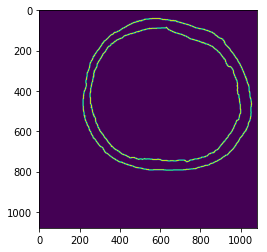

In [6]:
brightfield_path = '../../assets/sample_image_actin_surligned.tif'
img = cv.imread(brightfield_path, cv.IMREAD_GRAYSCALE).copy()
plt.show()
threshold = 2
_, img = cv.threshold(img, threshold, 255, 0)
blur = 9
img = cv.GaussianBlur(img, (blur, blur), 0)
plt.imshow(img)

img, contours, _ = cv.findContours(img, cv.RETR_TREE,
                                   cv.CHAIN_APPROX_SIMPLE)
contours = np.array(contours)

contours_length = np.array([c.size for c in contours])
membrane_ind = np.argsort(contours_length)[-2:]

retained_contours = contours[membrane_ind]

# Segmentation

Loading network weights from 'weights_best.h5'.


Reseting datasets values with new specs


{'geometry': 'planar', 'R_in': 119.94799383544922, 'R_out': 134.21666275024415, 'R_vit': None}
0.9999999950313019
[[  -7.48230762 -107.20532446]
 [  -7.32080762 -107.36682446]
 [  -5.00597428 -107.4206578 ]
 ...
 [ -11.40543162 -107.15687446]
 [ -11.06651962 -107.17302446]
 [ -10.72781162 -107.18917446]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffa840ae048>)

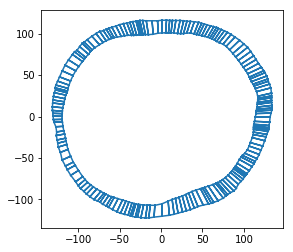

In [8]:
brigthfield_path = '../../assets/sample_image_actin_surligned.tif'
#dapi_path = '/home/fquinton/Documents/tyssue-taylor/assets/CELLPROFILER_sample_image_dapi.tiff.csv'
dapi_path = '../../assets/sample_image_dapi.tiff'
scp_path = '../../assets/star_convex_polynoms/models'
#initialising the mesh
real_organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path,
                                                           threshold=2,
                                                           method='SCP',
                                                           scp_model_path=scp_path,
                                                           rol_window_inside=20,
                                                           rol_window_outside=5)

#mlat = np.sum(inners[:, 0]) / len(inners)
#mlng = np.sum(inners[:, 1]) / len(inners)
#def algo(x):
#    return (math.atan2(x[0] - mlat, x[1] - mlng) + 2 * math.pi) % (2*math.pi)
#sort_inners = [list(inner) for inner in inners]
#sort_inners.sort(key=algo)
#inners = np.array(sort_inners)

#mlat = np.sum(outers[:, 0]) / len(outers)
#mlng = np.sum(outers[:, 1]) / len(outers)
#def algo(x):
#    return (math.atan2(x[0] - mlat, x[1] - mlng) + 2 * math.pi) % (2*math.pi)

#sort_outers = [list(outer) for outer in outers]
#sort_outers.sort(key=algo)
#outers = np.array(sort_outers)

Nf = real_organo.Nf
geom.update_all(real_organo)
#normalize_scale(real_organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + np.sin(np.pi/Nf)/(np.mean(real_organo.face_df.area)*real_organo.settings['R_in']*np.sin(2*np.pi/Nf)-2*np.mean(real_organo.face_df.area)*
                             np.sin(2*np.pi/Nf)*(8-2*(np.sin(2*np.pi/Nf)**2-4)/(np.sin(np.pi/Nf)**4+8*np.sin(np.pi/Nf)**2)
                                                )*(real_organo.settings['R_in']+real_organo.settings['R_out']))
print(alpha)
alpha = 1.001
print(inners)

# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*real_organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': real_organo.settings['lumen_volume'],
        'lumen_volume': real_organo.settings['lumen_volume']
        }
    }

#inners = inners[230:1175]

real_organo.update_specs(specs, reset=True)
geom.update_all(real_organo)

real_organo.vert_df[['x_ecm', 'y_ecm']] = real_organo.vert_df[['x', 'y']]

real_organo.vert_df.loc[real_organo.basal_verts, 'adhesion_strength'] = 0.01

quick_edge_draw(real_organo)

In [9]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*real_organo.Nf),[1000]*(3*real_organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

Solving time: 21.811409000000005
Distance from th organo to exp organo : 2039.4162279564232
Distance from th tensions to exp tensions : 113.75524024419003


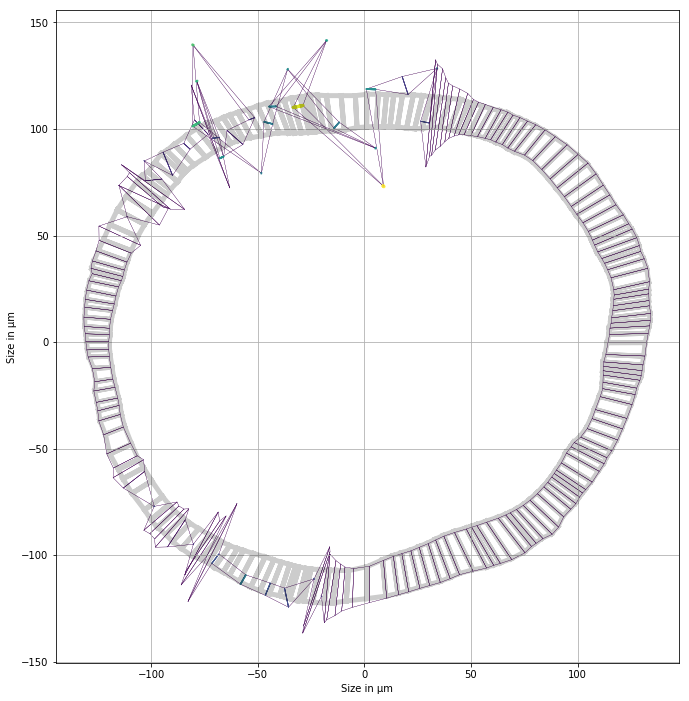

In [10]:
nb_cells = real_organo.Nf
initial_guess = infer_forces(real_organo, 'NNLS', sup_param='')
start = time.clock()
tensions_real_organo = real_organo.copy()
tensions_real_organo.edge_df.line_tension = prepare_tensions(tensions_real_organo,
                                                            initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(tensions_real_organo, False))
Solver.find_energy_min(tensions_real_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(tensions_real_organo, False))
print_tensions(tensions_real_organo, real_organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(real_organo, tensions_real_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(real_organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

# Scaling factor optimization

iter   time      nfev    incumbent   f(incumbent)
   1   224.25      10      0.00000     2.61799
   2   361.55      15      0.00000     2.61799
   3   485.58      20      0.00000     2.61799
   4   664.18      25      0.00000     2.61799
Brut force search summary
              solving time: 664.1778082847595
              nb iter: 4
              nfev: 25
              x_ub: 0.0
              ub: 2.617989053573852
Optimization terminated successfully.
         Current function value: 2.614220
         Iterations: 7
         Function evaluations: 14
Solving time: 759.446224
Distance from th real_organo to exp real_organo : 2.614220102652278
Distance from th tensions to exp tensions : 2.26118936995565


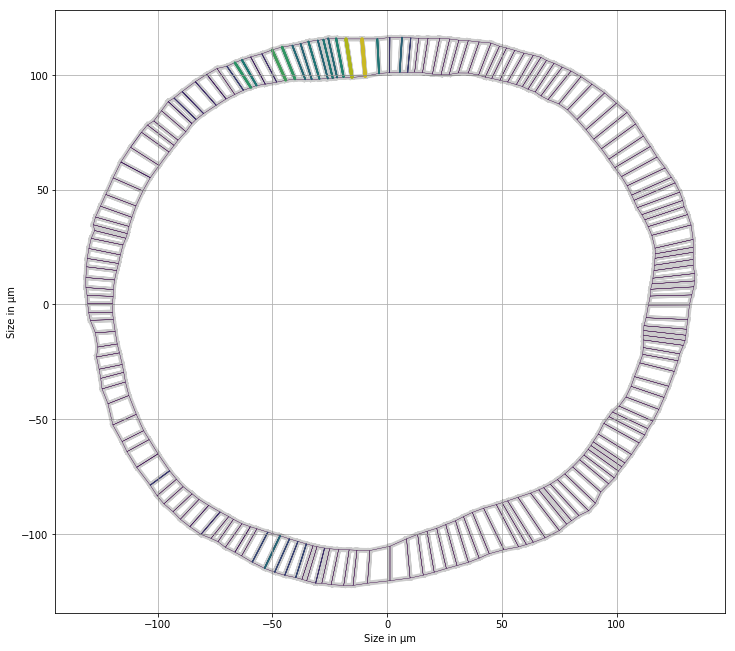

In [11]:
initial_guess = infer_forces(real_organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_tensions_real_organo = real_organo.copy()
opt_scale = adjust_scale(real_organo,
                         initial_guess['tensions'],
                         verbose=2,
                         **nm_opt)
rescaled_tensions_real_organo.edge_df.line_tension = prepare_tensions(rescaled_tensions_real_organo,
                                                                 opt_scale.x*initial_guess['tensions'])
Solver.find_energy_min(rescaled_tensions_real_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_tensions_real_organo, real_organo)
print('Distance from th real_organo to exp real_organo : ' +
      str(np.sum(np.linalg.norm(_distance(real_organo, rescaled_tensions_real_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(real_organo.edge_df.line_tension[:3*nb_cells] -
                                rescaled_tensions_real_organo.edge_df.line_tension[:3*nb_cells]))))

In [12]:
dist_init_point = np.sum(np.linalg.norm(_distance(tensions_real_organo, real_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(real_organo, rescaled_tensions_real_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(real_organo.edge_df.line_tension[:3*nb_cells] -
                                             tensions_real_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(real_organo.edge_df.line_tension[:3*nb_cells] -
                                         rescaled_tensions_real_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th real_organo to exp real_organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 2039.4162279564232
Distance from th real_organo to exp real_organo at optima: 2.614220102652278
Distance from th tensions to exp tensions at initial point : 113.75524024419003
Distance from th tensions to exp tensions at initial point : 2.26118936995565


In [13]:
opt_scale.x

array([0.00015625])

# Distance minimization

`xtol` termination condition is satisfied.
Function evaluations 1046, initial cost 1.6668e-02, final cost 1.6668e-02, first-order optimality 1.21e-03.
Solving time: 2284.8313
Distance from th real_organo to exp real_organo : 2.6141701755111493
Distance from th tensions to exp tensions : 2.2611767449772904


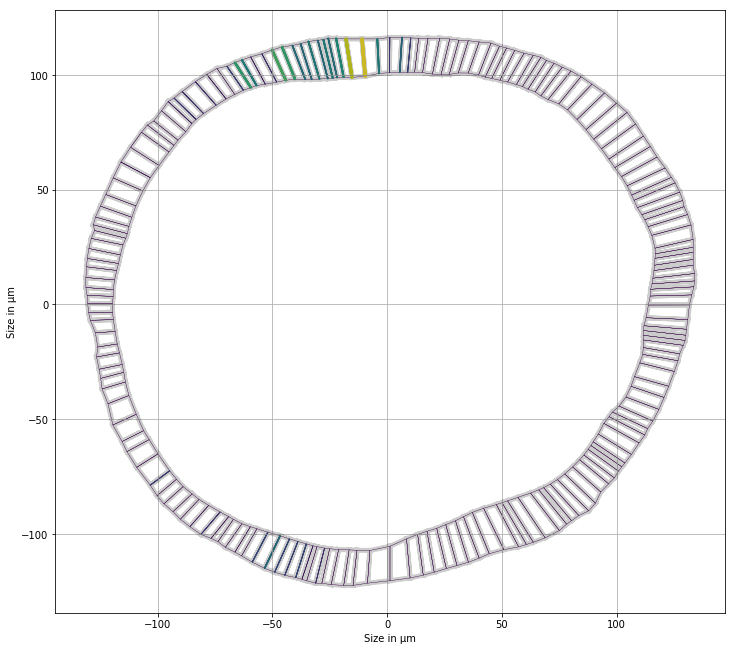

In [14]:
iprint_file = "../../assets/dist_at_each_f_ev/real_only_tensions.txt"
res_real_tensions = adjust_tensions(real_organo, opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_tensions_real_organo = real_organo.copy()
opt_tensions_real_organo.edge_df.line_tension = prepare_tensions(opt_tensions_real_organo, res_real_tensions.x)
Solver.find_energy_min(opt_tensions_real_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_real_organo, real_organo)
print('Distance from th real_organo to exp real_organo : ' +
      str(np.sum(np.linalg.norm(_distance(real_organo, opt_tensions_real_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(real_organo.edge_df.line_tension[:3*nb_cells] -
                                opt_tensions_real_organo.edge_df.line_tension[:3*nb_cells]))))

In [15]:
dist_init_point = np.sum(np.linalg.norm(_distance(rescaled_tensions_real_organo, real_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(real_organo, opt_tensions_real_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(real_organo.edge_df.line_tension[:3*nb_cells] -
                                             rescaled_tensions_real_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(real_organo.edge_df.line_tension[:3*nb_cells] -
                                         opt_tensions_real_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th real_organo to exp real_organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 2.614220102652278
Distance from th real_organo to exp real_organo at optima: 2.6141701755111493
Distance from th tensions to exp tensions at initial point : 2.26118936995565
Distance from th tensions to exp tensions at initial point : 2.2611767449772904


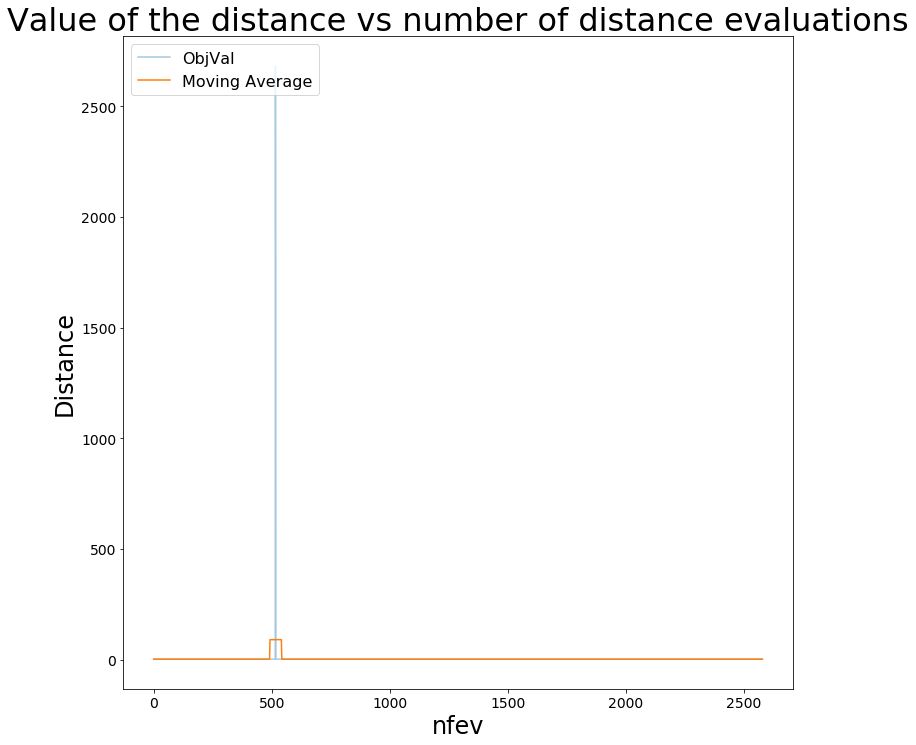

In [20]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 7 Text yticklabel objects>)

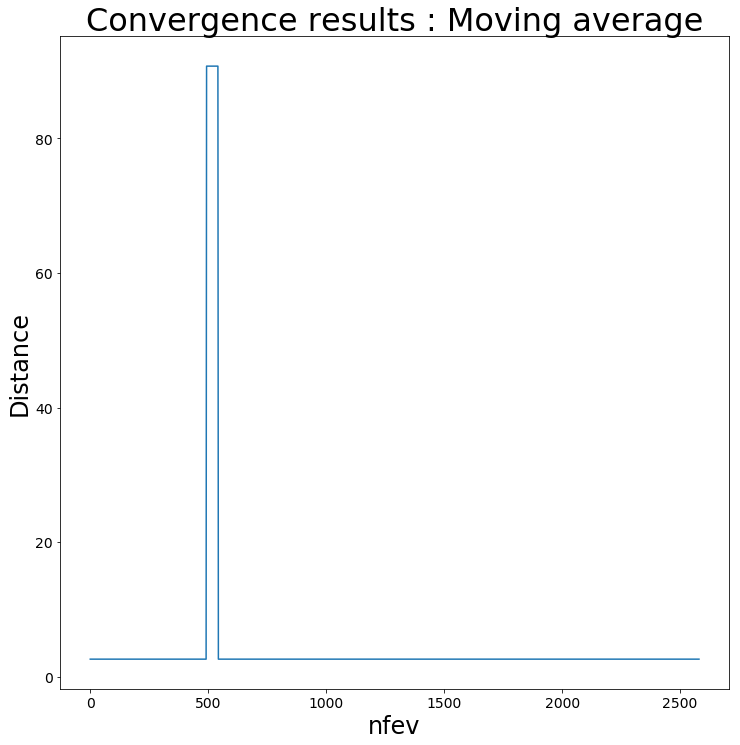

In [21]:
rolling = iter_data.rolling(50, min_periods=0, center=True).mean()
fig, ax = plt.subplots()
plt.plot(np.arange(len(iter_data[0])), rolling, '-', markersize=20, alpha=1)
plt.title("Convergence results : Moving average", fontdict={'fontsize': 32})
plt.xlabel("nfev", fontdict={'fontsize': 24})
plt.ylabel("Distance", fontdict={'fontsize': 24})
fig.set_size_inches(12, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)